# Import necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D

from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, recall_score, precision_score, make_scorer,roc_auc_score

from sklearn.model_selection import GridSearchCV
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split, cross_val_score

# Import data

In [2]:
data = pd.read_csv('Lloyds_data.csv')
data.drop(['Unnamed: 0','timestamp','at_risk_behaviour_window'], axis=1, inplace=True)

In [3]:
data.head(15)

,individual_id,date,day_of_week,hour_of_day,department,spend,at_risk_event
0,1,09/01/2023,Monday,11.994438,ops,2.10,False
1,1,11/01/2023,Wednesday,9.167461,ops,4.45,False
2,1,12/01/2023,Thursday,8.863522,ops,3.94,False
3,1,12/01/2023,Thursday,10.737514,ops,2.72,False
4,1,12/01/2023,Thursday,13.516375,ops,1.50,False
5,1,13/01/2023,Friday,9.536425,ops,3.02,False
6,1,15/01/2023,Sunday,15.233191,ops,8.14,True
7,1,16/01/2023,Monday,13.966903,ops,2.39,False
8,1,17/01/2023,Tuesday,9.264816,ops,9.22,False
9,1,18/01/2023,Wednesday,12.883891,ops,8.22,False


# 2. EDA

## Calculate of number of people and transaction records in different departments

In [4]:
# Calculate the number of entries (transactions) for each department
data_count = data.groupby('department').size().reset_index()
data_count.columns = ['department', 'data_count']

# Calculate the number of unique individual_ids for each department
individual_count = data.groupby('department')['individual_id'].nunique().reset_index()
individual_count.columns = ['department', 'individual_count']

result = pd.merge(data_count, individual_count, on='department')

result.head(20)

,department,data_count,individual_count
0,accounting,6713,160
1,development,2565,57
2,exec,1185,19
3,finance,6137,130
4,general,2110,57
5,human_resources,5790,117
6,investor_relations,1727,41
7,it,4883,101
8,legal,10008,209
9,marketing,8897,178


## Risk record percentage distribution over a week in total transaction records

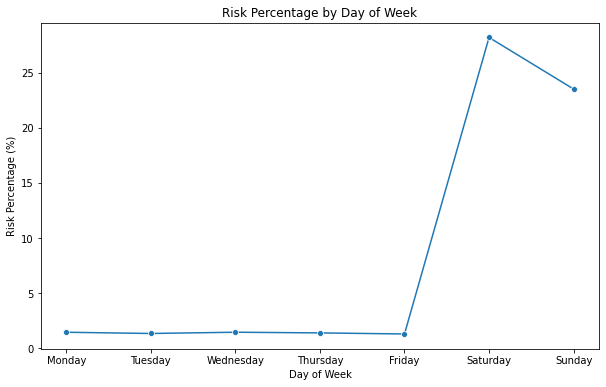

In [5]:
# Calculate the percentage of at_risk_event being True for each day_of_week
risk_percentage = data.groupby('day_of_week')['at_risk_event'].mean().reset_index()
risk_percentage['risk_percentage'] = risk_percentage['at_risk_event'] * 100

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
risk_percentage['day_of_week'] = pd.Categorical(risk_percentage['day_of_week'], categories=day_order, ordered=True)
risk_percentage = risk_percentage.sort_values('day_of_week')

plt.figure(figsize=(10, 6))
sns.lineplot(data=risk_percentage, x='day_of_week', y='risk_percentage', marker='o')

plt.title('Risk Percentage by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Risk Percentage (%)')

# plt.savefig('risk_percentage_by_day_of_week.png')

plt.show()

## Risk record percentage distribution over a day in total transaction records

In [6]:
# Convert hour_of_day to a 0-24 hour format, rounding up
data['hours'] = data['hour_of_day'].apply(np.ceil)

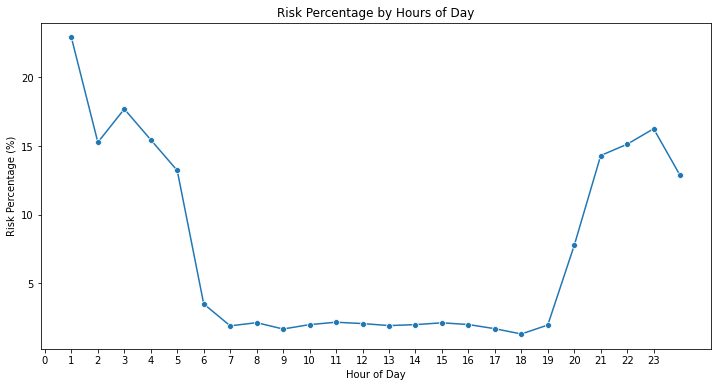

In [7]:
# Calculate the percentage of at_risk_event being True for each hour_of_day
risk_percentage = data.groupby('hours')['at_risk_event'].mean().reset_index()
risk_percentage['risk_percentage'] = risk_percentage['at_risk_event'] * 100

risk_percentage = risk_percentage.sort_values('hours')

plt.figure(figsize=(12, 6))
sns.lineplot(data=risk_percentage, x='hours', y='risk_percentage', marker='o')
plt.title('Risk Percentage by Hours of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Risk Percentage (%)')
plt.xticks(range(0, 24))

plt.savefig('risk_percentage_by_hours_of_day.png')
plt.show()

# 3. Feature Engineering

## 3.1 Risk-related feature labels

### For spend

In [8]:
# Calculate the difference in spend compared to the previous record for each individual_id
data['spend_difference'] = data.groupby('individual_id')['spend'].transform(lambda x: x.diff())

In [9]:
# Identify positive outliers using the IQR method
def identify_positive_outliers_iqr(series, threshold=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    upper_bound = q3 + threshold * iqr
    return (series > upper_bound).astype(int)

data['is_positive_outlier_iqr'] = data.groupby('individual_id')['spend_difference'].transform(identify_positive_outliers_iqr)

In [10]:
# Define a window function to mark risks
def mark_spend_risk(df, window_size=5):
    risk = [0] * len(df)
    is_in_risk_window = [False] * len(df)
    
    for idx in range(len(df)):
        if df.iloc[idx]['is_positive_outlier_iqr'] == 1:
            if not any(is_in_risk_window[max(0, idx - window_size + 1):idx + 1]):
                risk[idx] = 1
                for i in range(idx + 1, min(len(df), idx + window_size)):
                    is_in_risk_window[i] = True
    return risk

# Apply risk marking function to each individual_id
data['spend_risk'] = data.groupby('individual_id').apply(lambda x: mark_spend_risk(x)).explode().reset_index(level=0, drop=True)

###  For weekday

In [11]:
# Define weekdays as Monday to Friday
workdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

data['working_day'] = np.where((data['day_of_week'].isin(workdays)), 1, 0)

In [12]:
# Define a window function to mark risks
def mark_weekday_risk(df, window_size=7):
    risk = [0] * len(df)
    is_in_risk_window = [False] * len(df)
    
    for idx in range(len(df)):
        if df.iloc[idx]['working_day'] == 0:
            if not any(is_in_risk_window[max(0, idx - window_size + 1):idx + 1]):
                risk[idx] = 1
                for i in range(idx + 1, min(len(df), idx + window_size)):
                    is_in_risk_window[i] = True
    return risk

# Apply risk marking function to each individual_id
data['weekday_risk'] = data.groupby('individual_id').apply(lambda x: mark_weekday_risk(x)).explode().reset_index(level=0, drop=True)

####  Label employees who frequently work on weekends

In [13]:
working_day_stats = data.groupby('individual_id')['working_day'].mean().reset_index()
working_day_stats.columns = ['individual_id', 'working_day_work_ratio']
working_day_stats['non_working_day_stats'] = 1-working_day_stats['working_day_work_ratio']

In [14]:
data = data.merge(working_day_stats, on='individual_id')

In [15]:
# Ensure the data type of the weekday_risk column is integer
data['weekday_risk'] = data['weekday_risk'].astype(int)

# Keep only the first risk label if the proportion exceeds 10%
def adjust_risk_flags(df):
    if df['non_working_day_stats'].iloc[0] > 0.1:
        first_risk_idx = df.index[df['weekday_risk'] == 1][0]
        df['weekday_risk'] = 0
        df.at[first_risk_idx, 'weekday_risk'] = 1
    return df

data = data.groupby('individual_id', group_keys=False).apply(adjust_risk_flags)

### For hours of the day

In [16]:
# Create a new variable working_hours
data['working_hours'] = np.where((data['hour_of_day'] >= 8) & (data['hour_of_day'] <= 18), 1, 0)

In [17]:
# Define a window function to mark risks
def mark_hours_risk(df, window_size=5):
    risk = [0] * len(df)
    is_in_risk_window = [False] * len(df)
    
    for idx in range(len(df)):
        if df.iloc[idx]['hour_of_day'] < 8 or df.iloc[idx]['hour_of_day'] > 18:
            if not any(is_in_risk_window[max(0, idx - window_size + 1):idx + 1]):
                risk[idx] = 1
                for i in range(idx + 1, min(len(df), idx + window_size)):
                    is_in_risk_window[i] = True
    return risk

# Apply risk marking function to each individual_id
data['hours_risk'] = data.groupby('individual_id').apply(lambda x: mark_hours_risk(x)).explode().reset_index(level=0, drop=True)


####  Label employees who frequently work outside normal working hours

In [18]:
working_hours_stats = data.groupby('individual_id')['working_hours'].mean().reset_index()
working_hours_stats.columns = ['individual_id', 'working_hours_stats']
working_hours_stats['non_working_hours_stats'] = 1-working_hours_stats['working_hours_stats']

In [19]:
data = data.merge(working_hours_stats, on='individual_id')

In [20]:
data['hours_risk'] = data['hours_risk'].astype(int)

# Keep only the first risk label if the proportion exceeds 10%
def adjust_risk_flags_hours(df):
    if df['non_working_hours_stats'].iloc[0] > 0.1:
        first_risk_idx = df.index[df['hours_risk'] == 1][0]
        df['hours_risk'] = 0
        df.at[first_risk_idx, 'hours_risk'] = 1
    return df

# Apply adjusted risk marking function
data = data.groupby('individual_id', group_keys=False).apply(adjust_risk_flags_hours)

## 3.2 Cluster analysis

### Cluster the departments

In [21]:
# Calculate the median and standard deviation of spend for each department
department_stats = data.groupby('department')['spend'].agg(['median', 'std']).reset_index()

In [22]:
# Calculate the proportion of non-working day work for each department
non_working_day_work_ratio_depart = data.groupby(['department'])['working_day'].mean().reset_index()
non_working_day_work_ratio_depart['non_working_day_work_ratio'] = 1 - non_working_day_work_ratio_depart['working_day']
non_working_day_work_ratio_depart.drop(columns=['working_day'], inplace=True)

In [23]:
# Calculate the proportion of work outside normal working hours for each department
department_non_work_time_ratio = data.groupby(['department'])['working_hours'].mean().reset_index()
department_non_work_time_ratio['non_work_time_ratio'] = 1 - department_non_work_time_ratio['working_hours']
department_non_work_time_ratio.drop(columns=['working_hours'], inplace=True)

In [24]:
department_stats_final = department_stats.merge(non_working_day_work_ratio_depart, on='department')
department_stats_final = department_stats_final.merge(department_non_work_time_ratio, on='department')

In [25]:
# Set different weights
weights = {
    'median': 1.0,
    'std': 1.0,
    'non_working_day_work_ratio': 2.0,
    'non_work_time_ratio': 2.0
}


features = department_stats_final[['median', 'std', 'non_working_day_work_ratio', 'non_work_time_ratio']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Perform weighting
weighted_features = scaled_features * np.array([weights[col] for col in features.columns])

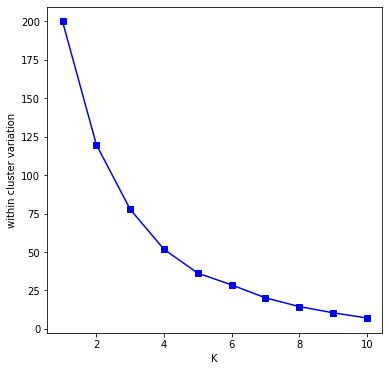

In [26]:
# Plot inter-cluster variance changes for different numbers of clusters (K)
K = np.arange(1,11)
WCV = np.zeros(K.shape)

for i in range(K.shape[0]):
    kmeans_K = KMeans(n_clusters = K[i], n_init = 10, random_state=0).fit(weighted_features)
    WCV[i] = kmeans_K.inertia_

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.plot(K, WCV, c='b',marker='s')
plt.xlabel('K')
plt.ylabel('within cluster variation')
# plt.savefig('within cluster variation department.png')
plt.show()

In [27]:
# Apply K-means with chosen K 
kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
department_stats_final['cluster'] = kmeans.fit_predict(weighted_features)

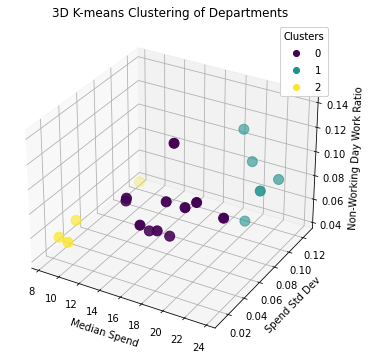

In [28]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(department_stats_final['std'], department_stats_final['non_working_day_work_ratio'],department_stats_final['non_work_time_ratio'],
                     c=department_stats_final['cluster'], cmap='viridis', s=100)

ax.set_xlabel('Median Spend')
ax.set_ylabel('Spend Std Dev')
ax.set_zlabel('Non-Working Day Work Ratio')
ax.set_title('3D K-means Clustering of Departments')

legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)
# plt.savefig('3D K-means Clustering of Departments.png')
plt.show()

In [29]:
# Merge the clustering results back into the original data
data_with_clusters = data.merge(department_stats_final[['department', 'cluster']], on='department', how='left')

### Cluster employees within each department category

In [30]:
# Calculate the median and standard deviation of spend for each individual
individual_stats = data.groupby('individual_id')['spend'].agg(['median', 'std']).reset_index()
# Set standard deviation to 0 in cases where there is only one data point
individual_stats['std'] = individual_stats['std'].fillna(0)

In [31]:
# Calculate the proportion of non-working day work for each individual
non_working_day_work_ratio_indiv = data.groupby(['individual_id'])['working_day'].mean().reset_index()
non_working_day_work_ratio_indiv['non_working_day_work_ratio'] = 1 - non_working_day_work_ratio_indiv['working_day']
non_working_day_work_ratio_indiv.drop(columns=['working_day'], inplace=True)

In [32]:
# Calculate the proportion of work outside normal working hours for each individual
individual_non_work_time_ratio = data.groupby(['individual_id'])['working_hours'].mean().reset_index()
individual_non_work_time_ratio['non_work_time_ratio'] = 1 - individual_non_work_time_ratio['working_hours']
individual_non_work_time_ratio.drop(columns=['working_hours'], inplace=True)

In [33]:
individual_stats_final = individual_stats.merge(non_working_day_work_ratio_indiv, on='individual_id')
individual_stats_final = individual_stats_final.merge(individual_non_work_time_ratio, on='individual_id')

In [34]:
# Merge department and cluster columns into the individual_stats_final dataframe
data_unique = data_with_clusters[['individual_id', 'department', 'cluster']]
data_unique = data_unique.drop_duplicates(subset='individual_id')
individual_stats_final = individual_stats_final.merge(data_unique[['individual_id', 'department', 'cluster']], on='individual_id', how='left')

In [35]:
# Define an employee clustering function
def hierarchical_clustering(data, n_clusters, weights):
   
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
    weighted_data = scaled_data * np.array([weights[col] for col in data.columns])
    
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clustering.fit_predict(weighted_data)
    return cluster_labels

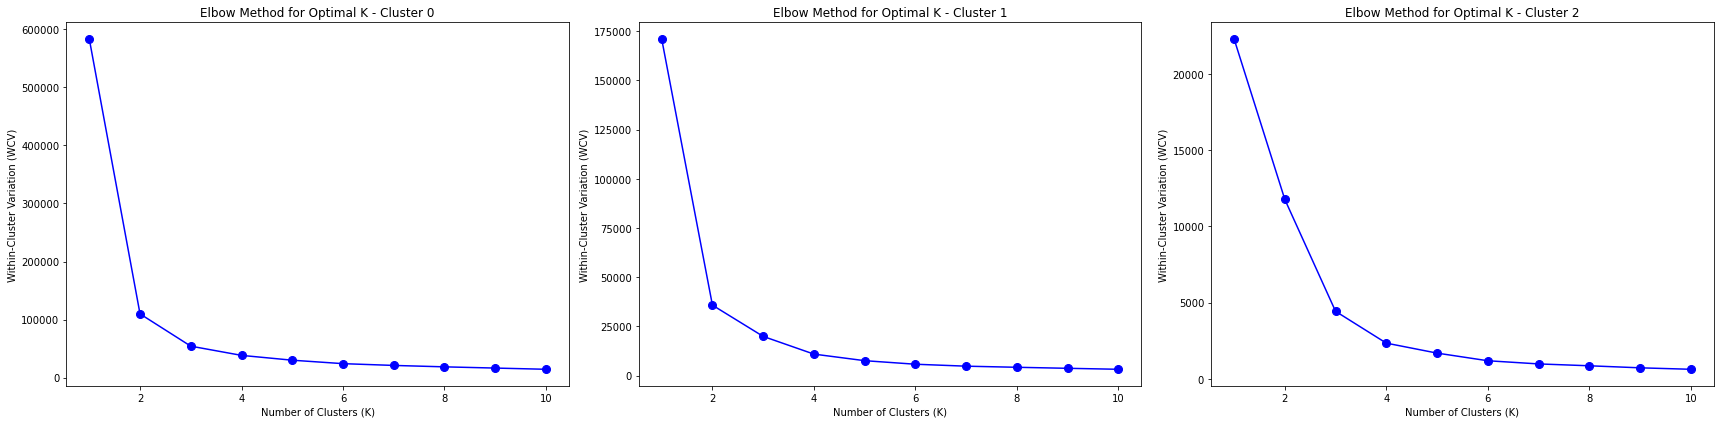

<Figure size 432x288 with 0 Axes>

In [36]:
# Perform clustering in each initial K-means cluster
individual_stats_final['individual_cluster'] = np.nan
fig, axs = plt.subplots(1, 3, figsize=(24, 6))  
for idx, cluster in enumerate(individual_stats_final['cluster'].unique()):
    cluster_data = individual_stats_final[individual_stats_final['cluster'] == cluster]
    
    features = cluster_data[['median', 'std', 'non_working_day_work_ratio', 'non_work_time_ratio']]
    weights = {'median': 1.0, 'std': 2.0, 'non_working_day_work_ratio': 3.0, 'non_work_time_ratio': 3.0}
    
    # Find the optimal number of clusters
    K = np.arange(1, 11)
    WCV = np.zeros(K.shape)

    for i in range(K.shape[0]):
        kmeans_K = KMeans(n_clusters=K[i], n_init=10, random_state=0).fit(features * np.array([weights[col] for col in features.columns]))
        WCV[i] = kmeans_K.inertia_

    # Plot an elbow method graph
    axs[idx].plot(K, WCV, 'bo-', markersize=8)
    axs[idx].set_xlabel('Number of Clusters (K)')
    axs[idx].set_ylabel('Within-Cluster Variation (WCV)')
    axs[idx].set_title(f'Elbow Method for Optimal K - Cluster {cluster}')
    #plt.savefig(f'Elbow Method for Optimal K - Cluster {cluster}.png')
plt.tight_layout()
plt.show()
plt.savefig('Elbow Method for Optimal K - Each cluster.png')

In [37]:
individual_stats_final['individual_cluster'] = np.nan
optimal_k=[2,2,3]

for cluster in individual_stats_final['cluster'].unique():
    cluster_data = individual_stats_final[individual_stats_final['cluster'] == cluster]
    
    # Select features for the second round of clustering
    features = cluster_data[['median', 'std', 'non_working_day_work_ratio', 'non_work_time_ratio']]
    weights = {'median': 1.0, 'std': 2.0, 'non_working_day_work_ratio': 3.0, 'non_work_time_ratio': 3.0}
    
    # Perform clustering based on the optimal K
    individual_clusters = hierarchical_clustering(features, n_clusters=optimal_k[cluster], weights=weights)
    
    individual_stats_final.loc[individual_stats_final['cluster'] == cluster, 'individual_cluster'] = individual_clusters


In [38]:
data_with_clusters = data_with_clusters.merge(individual_stats_final[['individual_id', 'individual_cluster']], on='individual_id', how='left')

data_with_clusters.head(20)

,individual_id,date,day_of_week,hour_of_day,department,spend,at_risk_event,hours,spend_difference,is_positive_outlier_iqr,...,working_day,weekday_risk,working_day_work_ratio,non_working_day_stats,working_hours,hours_risk,working_hours_stats,non_working_hours_stats,cluster,individual_cluster
0,1,09/01/2023,Monday,11.994438,ops,2.10,False,12.0,NaN,0,...,1,0,0.980769,0.019231,1,0,0.961538,0.038462,0,1.0
1,1,11/01/2023,Wednesday,9.167461,ops,4.45,False,10.0,2.35,0,...,1,0,0.980769,0.019231,1,0,0.961538,0.038462,0,1.0
2,1,12/01/2023,Thursday,8.863522,ops,3.94,False,9.0,-0.51,0,...,1,0,0.980769,0.019231,1,0,0.961538,0.038462,0,1.0
3,1,12/01/2023,Thursday,10.737514,ops,2.72,False,11.0,-1.22,0,...,1,0,0.980769,0.019231,1,0,0.961538,0.038462,0,1.0
4,1,12/01/2023,Thursday,13.516375,ops,1.50,False,14.0,-1.22,0,...,1,0,0.980769,0.019231,1,0,0.961538,0.038462,0,1.0
5,1,13/01/2023,Friday,9.536425,ops,3.02,False,10.0,1.52,0,...,1,0,0.980769,0.019231,1,0,0.961538,0.038462,0,1.0
6,1,15/01/2023,Sunday,15.233191,ops,8.14,True,16.0,5.12,0,...,0,1,0.980769,0.019231,1,0,0.961538,0.038462,0,1.0
7,1,16/01/2023,Monday,13.966903,ops,2.39,False,14.0,-5.75,0,...,1,0,0.980769,0.019231,1,0,0.961538,0.038462,0,1.0
8,1,17/01/2023,Tuesday,9.264816,ops,9.22,False,10.0,6.83,0,...,1,0,0.980769,0.019231,1,0,0.961538,0.038462,0,1.0
9,1,18/01/2023,Wednesday,12.883891,ops,8.22,False,13.0,-1.00,0,...,1,0,0.980769,0.019231,1,0,0.961538,0.038462,0,1.0


# 4. Model

In [39]:
# Select features needed for modeling
model_columns = ['individual_id','spend','spend_risk','working_day','weekday_risk','working_hours','hours_risk','cluster','individual_cluster','at_risk_event']
model_data=data_with_clusters[model_columns]
model_data = pd.DataFrame(model_data)
model_data.head(20)

,individual_id,spend,spend_risk,working_day,weekday_risk,working_hours,hours_risk,cluster,individual_cluster,at_risk_event
0,1,2.10,0,1,0,1,0,0,1.0,False
1,1,4.45,0,1,0,1,0,0,1.0,False
2,1,3.94,0,1,0,1,0,0,1.0,False
3,1,2.72,0,1,0,1,0,0,1.0,False
4,1,1.50,0,1,0,1,0,0,1.0,False
5,1,3.02,0,1,0,1,0,0,1.0,False
6,1,8.14,0,0,1,1,0,0,1.0,True
7,1,2.39,0,1,0,1,0,0,1.0,False
8,1,9.22,0,1,0,1,0,0,1.0,False
9,1,8.22,0,1,0,1,0,0,1.0,False


In [40]:
# Calculate the risk ratio for the entire dataset
true_ratio = model_data['at_risk_event'].mean()
# Calculate the risk ratio for different clusters
risk_ratio_per_cluster = model_data.groupby('cluster')['at_risk_event'].mean()
# Convert results to a dictionary
risk_ratio_per_cluster_dict = risk_ratio_per_cluster.to_dict()
print(true_ratio)
print(risk_ratio_per_cluster_dict)

0.026321038783399982
{0: 0.02295475959634581, 1: 0.036970281259169215, 2: 0.025399926730980585}


## Isolation Forest

### Model 1-Isolation Forest with parameters equal to the risk ratio of the entire dataset

In [41]:
features = ['spend','spend_risk', 'weekday_risk', 'hours_risk', 'individual_cluster']
scaler = MinMaxScaler()

# Create an empty DataFrame to store the final scores
evaluation_df = pd.DataFrame(columns=['Cluster', 'F1 Score', 'Recall', 'Precision'])

# Store y_true and y_pred for all clusters
all_y_true = np.array([])
all_y_pred = np.array([])

# Loop through each cluster
for cluster_id in model_data['cluster'].unique():
    cluster_data = model_data[model_data['cluster'] == cluster_id].copy()
    # Convert risk to 1 initially when calculating scores
    cluster_data.loc[:, 'risk'] = np.where(cluster_data['at_risk_event'] == 1, -1, 1)
    X = cluster_data[features]
    y_true = cluster_data['risk']
    y_true = np.where(y_true == 1, 0, 1)
    
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.3, random_state=28)
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define the model
    model1 = IsolationForest(contamination = true_ratio,random_state=28)
    model1.fit(X_train_scaled)
    
    y_pred = model1.predict(X_test_scaled)
    y_pred = np.where(y_pred == 1, 0, 1)
    
    # Calculate evaluation metrics for the test set
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    # Record evaluation metrics for the validation set
    evaluation_df = pd.concat([evaluation_df, pd.DataFrame([{
        'Cluster': cluster_id,
        'F1 Score': f1,
        'Recall': recall,
        'Precision': precision
    }])], ignore_index=True)
    
    all_y_true = np.concatenate([all_y_true, y_test])
    all_y_pred = np.concatenate([all_y_pred, y_pred])

# Calculate overall evaluation metrics for all clusters
total_f1 = f1_score(all_y_true, all_y_pred)
total_recall = recall_score(all_y_true, all_y_pred)
total_precision = precision_score(all_y_true, all_y_pred)

print(f"Total - F1 Score: {total_f1}, Recall: {total_recall}, Precision: {total_precision}")
print(evaluation_df)

Total - F1 Score: 0.47795823665893267, Recall: 0.4807467911318553, Precision: 0.47520184544405997
  Cluster  F1 Score    Recall  Precision
0       0  0.566637  0.616123   0.524510
1       1  0.269912  0.230189   0.326203
2       2  0.431655  0.422535   0.441176


### Model 2-Isolation Forest with parameters equal to the risk ratio of each department category

In [42]:
evaluation_2 = pd.DataFrame(columns=['Cluster', 'F1 Score', 'Recall', 'Precision'])

all_y_true = np.array([])
all_y_pred = np.array([])

# Loop through each cluster
for cluster_id in model_data['cluster'].unique():
    # Convert risk to 1 initially when calculating scores
    cluster_data = model_data[model_data['cluster'] == cluster_id].copy()
    cluster_data.loc[:, 'risk'] = np.where(cluster_data['at_risk_event'] == 1, -1, 1)
    X = cluster_data[features]
    y_true = cluster_data['risk']
    y_true = np.where(y_true == 1, 0, 1)
    
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.3, random_state=28)
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define the model - different clusters use different parameters compared to model 1
    contamination = risk_ratio_per_cluster_dict.get(cluster_id, true_ratio)
    print(f"Cluster {cluster_id}: Contamination = {contamination}")
    model2 = IsolationForest(contamination = contamination,random_state=28)
    model2.fit(X_train_scaled)
    
    y_pred = model2.predict(X_test_scaled)
    y_pred = np.where(y_pred == 1, 0, 1)
    
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    evaluation_2 = pd.concat([evaluation_2, pd.DataFrame([{
        'Cluster': cluster_id,
        'F1 Score': f1,
        'Recall': recall,
        'Precision': precision
    }])], ignore_index=True)
    
    all_y_true = np.concatenate([all_y_true, y_test])
    all_y_pred = np.concatenate([all_y_pred, y_pred])

# Calculate overall evaluation metrics for all clusters
total_f1 = f1_score(all_y_true, all_y_pred)
total_recall = recall_score(all_y_true, all_y_pred)
total_precision = precision_score(all_y_true, all_y_pred)

print(f"Total - F1 Score: {total_f1}, Recall: {total_recall}, Precision: {total_precision}")
print(evaluation_2)

Cluster 0: Contamination = 0.02295475959634581
Cluster 1: Contamination = 0.036970281259169215
Cluster 2: Contamination = 0.025399926730980585
Total - F1 Score: 0.47949162333911033, Recall: 0.48424737456242706, Precision: 0.4748283752860412
  Cluster  F1 Score    Recall  Precision
0       0  0.594492  0.600768   0.588346
1       1  0.272560  0.279245   0.266187
2       2  0.414815  0.394366   0.437500


## OC-SVM

### Model 3:  OC-SVM with parameters equal to the risk ratio of the entire dataset - select training set based on 'at_risk_event'

In [43]:
# Use risk labels to filter the training set
features_all = ['spend', 'spend_risk','weekday_risk','working_day','hours_risk','working_hours','individual_cluster','risk']
evaluation_3 = pd.DataFrame(columns=['Cluster', 'F1 Score', 'Recall', 'Precision'])

all_y_true = np.array([])
all_y_pred = np.array([])

# Loop through each cluster
for cluster_id in model_data['cluster'].unique():
    # Convert risk to 1 initially when calculating scores
    cluster_data = model_data[model_data['cluster'] == cluster_id].copy()
    cluster_data.loc[:, 'risk'] = np.where(cluster_data['at_risk_event'] == 1, -1, 1)
    X = cluster_data[features_all]
    y_true = cluster_data['risk']
    y_true = np.where(y_true == 1, 0, 1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.3, random_state=28)
    
    # Keep only normal samples in the training set; both normal and anomalous samples in the test set
    X_train_normal = X_train[X_train['risk'] == 1]
    y_train_normal = y_train[X_train['risk'] == 1]
    X_train_normal = X_train_normal[features]
    X_test = X_test[features]
    X_test_scaled = scaler.fit_transform(X_test)
    
    X_train_scaled = scaler.transform(X_train_normal)
   
    model3 = OneClassSVM(kernel = 'rbf',nu = true_ratio, gamma = 'auto')
    model3.fit(X_train_scaled)
    
    y_pred = model3.predict(X_test_scaled)
    y_pred = np.where(y_pred == 1, 0, 1)
    
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    evaluation_3 = pd.concat([evaluation_3, pd.DataFrame([{
        'Cluster': cluster_id,
        'F1 Score': f1,
        'Recall': recall,
        'Precision': precision
    }])], ignore_index=True)
    
    all_y_true = np.concatenate([all_y_true, y_test])
    all_y_pred = np.concatenate([all_y_pred, y_pred])

# Calculate overall evaluation metrics for all clusters
total_f1 = f1_score(all_y_true, all_y_pred)
total_recall = recall_score(all_y_true, all_y_pred)
total_precision = precision_score(all_y_true, all_y_pred)

print(f"Total - F1 Score: {total_f1}, Recall: {total_recall}, Precision: {total_precision}")
print(evaluation_3)

Total - F1 Score: 0.5047662278710848, Recall: 0.6487747957992999, Precision: 0.413075780089153
  Cluster  F1 Score    Recall  Precision
0       0  0.480783  0.660269   0.378022
1       1  0.530478  0.607547   0.470760
2       2  0.618182  0.718310   0.542553


### Model 4: OC-SVM with parameters equal to the risk ratio of each department category - select training set based on 'at_risk_event'

In [44]:
evaluation_4 = pd.DataFrame(columns=['Cluster', 'F1 Score', 'Recall', 'Precision'])

all_y_true = np.array([])
all_y_pred = np.array([])

# Loop through each cluster
for cluster_id in model_data['cluster'].unique():
    # Convert risk to 1 initially when calculating scores
    cluster_data = model_data[model_data['cluster'] == cluster_id].copy()
    cluster_data.loc[:, 'risk'] = np.where(cluster_data['at_risk_event'] == 1, -1, 1)
    X = cluster_data[features_all]
    y_true = cluster_data['risk']
    y_true = np.where(y_true == 1, 0, 1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.3, random_state=28)
    
    # Keep only normal samples in the training set; both normal and anomalous samples in the test set
    X_train_normal = X_train[X_train['risk'] == 1]
    y_train_normal = y_train[X_train['risk'] == 1]
    X_train_normal = X_train_normal[features]
    X_test = X_test[features]
    X_test_scaled = scaler.fit_transform(X_test)
    
    X_train_scaled = scaler.transform(X_train_normal)
   
    # Define the model - different clusters use different parameters compared to model 3
    nu = risk_ratio_per_cluster_dict.get(cluster_id, true_ratio)
    print(f"Cluster {cluster_id}: nu = {nu}")
    model4 = OneClassSVM(kernel = 'rbf',nu = nu, gamma = 'auto')
    model4.fit(X_train_scaled)
    
    y_pred = model4.predict(X_test_scaled)
    y_pred = np.where(y_pred == 1, 0, 1)
    
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    evaluation_4 = pd.concat([evaluation_4, pd.DataFrame([{
        'Cluster': cluster_id,
        'F1 Score': f1,
        'Recall': recall,
        'Precision': precision
    }])], ignore_index=True)
    
    all_y_true = np.concatenate([all_y_true, y_test])
    all_y_pred = np.concatenate([all_y_pred, y_pred])

# Calculate overall evaluation metrics for all clusters
total_f1 = f1_score(all_y_true, all_y_pred)
total_recall = recall_score(all_y_true, all_y_pred)
total_precision = precision_score(all_y_true, all_y_pred)

print(f"Total - F1 Score: {total_f1}, Recall: {total_recall}, Precision: {total_precision}")
print(evaluation_4)

Cluster 0: nu = 0.02295475959634581
Cluster 1: nu = 0.036970281259169215
Cluster 2: nu = 0.025399926730980585
Total - F1 Score: 0.51731893837157, Recall: 0.6709451575262544, Precision: 0.42093704245973645
  Cluster  F1 Score    Recall  Precision
0       0  0.496350  0.652591   0.400471
1       1  0.533333  0.694340   0.432941
2       2  0.625767  0.718310   0.554348


### Model 5: OC-SVM with parameters equal to the risk ratio of the entire dataset - ignore a small portion of outliers

In [45]:
evaluation_5 = pd.DataFrame(columns=['Cluster', 'F1 Score', 'Recall', 'Precision'])

all_y_true = np.array([])
all_y_pred = np.array([])

# Loop through each cluster
for cluster_id in model_data['cluster'].unique():
    # Convert risk to 1 initially when calculating scores
    cluster_data = model_data[model_data['cluster'] == cluster_id].copy()
    cluster_data.loc[:, 'risk'] = np.where(cluster_data['at_risk_event'] == 1, -1, 1)
    X = cluster_data[features]
    y_true = cluster_data['risk']
    y_true = np.where(y_true == 1, 0, 1)
    
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.3, random_state=28)
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define the model
    model5 = OneClassSVM(kernel = 'rbf',nu = true_ratio, gamma = 'auto')
    model5.fit(X_train_scaled)

    y_pred = model5.predict(X_test_scaled)
    y_pred = np.where(y_pred == 1, 0, 1)
    
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    evaluation_5 = pd.concat([evaluation_5, pd.DataFrame([{
        'Cluster': cluster_id,
        'F1 Score': f1,
        'Recall': recall,
        'Precision': precision
    }])], ignore_index=True)
    
    all_y_true = np.concatenate([all_y_true, y_test])
    all_y_pred = np.concatenate([all_y_pred, y_pred])

# Calculate overall evaluation metrics for all clusters
total_f1 = f1_score(all_y_true, all_y_pred)
total_recall = recall_score(all_y_true, all_y_pred)
total_precision = precision_score(all_y_true, all_y_pred)

print(f"Total - F1 Score: {total_f1}, Recall: {total_recall}, Precision: {total_precision}")
print(evaluation_5)

Total - F1 Score: 0.45353594389246055, Recall: 0.45274212368728123, Precision: 0.45433255269320844
  Cluster  F1 Score    Recall  Precision
0       0  0.505687  0.554702   0.464630
1       1  0.273148  0.222642   0.353293
2       2  0.588235  0.563380   0.615385


### Model 6: OC-SVM with parameters equal to the risk ratio of each department category - ignore a small portion of outliers

In [46]:
evaluation_6 = pd.DataFrame(columns=['Cluster', 'F1 Score', 'Recall', 'Precision'])

all_y_true = np.array([])
all_y_pred = np.array([])

# Loop through each cluster
for cluster_id in model_data['cluster'].unique():
    # Convert risk to 1 initially when calculating scores
    cluster_data = model_data[model_data['cluster'] == cluster_id].copy()
    cluster_data.loc[:, 'risk'] = np.where(cluster_data['at_risk_event'] == 1, -1, 1)
    X = cluster_data[features]
    y_true = cluster_data['risk']
    y_true = np.where(y_true == 1, 0, 1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.3, random_state=28)
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define the model - different clusters use different parameters compared to model 3
    nu = risk_ratio_per_cluster_dict.get(cluster_id, true_ratio)
    print(f"Cluster {cluster_id}: nu = {nu}")
    model6 = OneClassSVM(kernel = 'rbf',nu = nu, gamma = 'auto')
    model6.fit(X_train_scaled)
    
    y_pred = model6.predict(X_test_scaled)
    y_pred = np.where(y_pred == 1, 0, 1)
    
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    evaluation_6 = pd.concat([evaluation_6, pd.DataFrame([{
        'Cluster': cluster_id,
        'F1 Score': f1,
        'Recall': recall,
        'Precision': precision
    }])], ignore_index=True)
    
    all_y_true = np.concatenate([all_y_true, y_test])
    all_y_pred = np.concatenate([all_y_pred, y_pred])

# Calculate overall evaluation metrics for all clusters
total_f1 = f1_score(all_y_true, all_y_pred)
total_recall = recall_score(all_y_true, all_y_pred)
total_precision = precision_score(all_y_true, all_y_pred)

print(f"Total - F1 Score: {total_f1}, Recall: {total_recall}, Precision: {total_precision}")
print(evaluation_6)

Cluster 0: nu = 0.02295475959634581
Cluster 1: nu = 0.036970281259169215
Cluster 2: nu = 0.025399926730980585
Total - F1 Score: 0.45459871118922085, Recall: 0.45274212368728123, Precision: 0.45647058823529413
  Cluster  F1 Score    Recall  Precision
0       0  0.495310  0.506718   0.484404
1       1  0.334646  0.320755   0.349794
2       2  0.586466  0.549296   0.629032
